## 分类

### MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


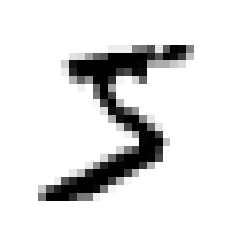

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
import numpy as np
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[6000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [5]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

### 性能测量

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [7]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [38]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

(60000,)
[ True False False ...  True False False]


In [9]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311
0.7325171197343846


In [10]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


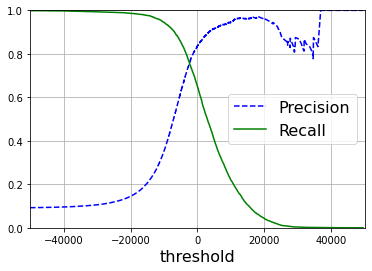

In [11]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [12]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


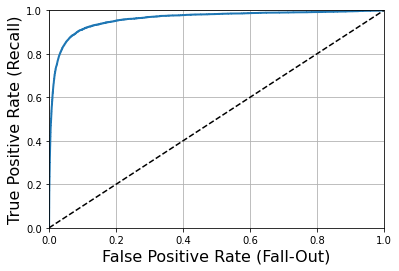

In [13]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

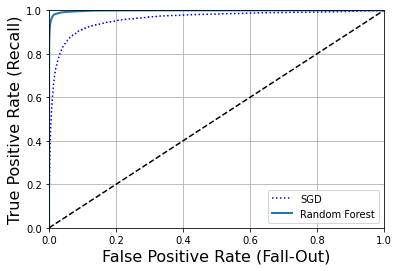

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [16]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 多类分类器

In [17]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [18]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]
5


In [19]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


In [21]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
print(sgd_clf.decision_function([some_digit]))

print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
[0.87365 0.85835 0.8689 ]


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

[0.8983 0.891  0.9018]


### 误差分析

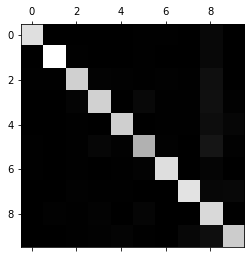

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

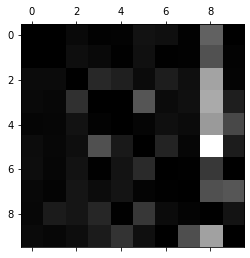

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

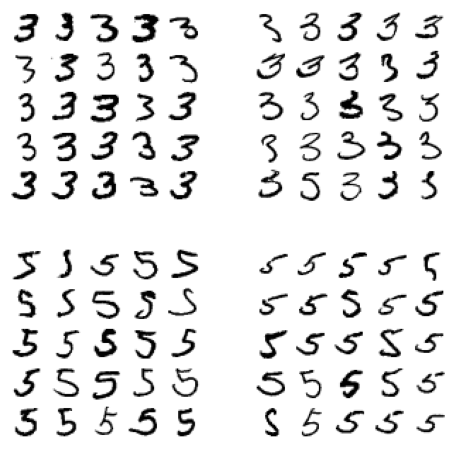

In [46]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### 多标签分类

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(knn_clf.predict([some_digit]))

[[False  True]]


In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average='macro'))

0.976410265560605
